In [2]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np


In [37]:
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution

    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

X =  tensor([10.0618,  7.9472, 10.4429,  7.1922,  9.6467,  9.1278,  8.7782, 12.6399,
        12.2380, 14.8455, 18.5024,  7.1587, 14.4738, 12.3287,  5.1583, 10.7395,
        12.4366, 10.7447,  7.3458,  6.8286, 31.6233, 29.8194, 29.8136, 29.9265,
        30.1692, 30.1574, 27.9861, 26.6355, 33.3034, 29.0105, 26.8917, 33.0355,
        26.9785, 29.8051, 27.5781, 31.9851, 27.9320, 29.0821, 28.7145, 29.7171])


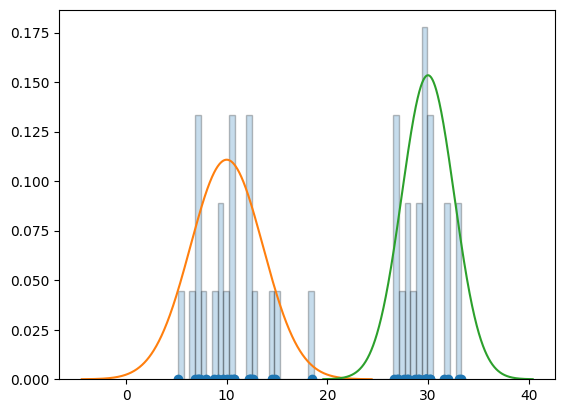

In [42]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

# a) Scatter Plot with histograms
# Histograms
plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
# Scatter
plt.scatter(X,torch.zeros(len(X)))
# Density
x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})')
plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})')
plt.show()



In [75]:
# 2)
def init_random_parameters(range=50):
  return torch.rand((2, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[ 0.2560,  2.2911],
        [ 5.6533, 17.4387]])


In [44]:
# 3)

# Este es para todo el dataset
def calculate_log_likelihood_gaussian_observation_dataset(x, mu, sigma):
  # TODO: (ESTA ES LA QUE HICIMOS EN LA CLASE)
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  N = x.shape[0]
  return -(N / 2) * torch.log(torch.tensor(2 * torch.pi)) - N * torch.log(torch.tensor(sigma)) - (1 / (2 * sigma**2)) * torch.sum((x - mu) ** 2)

# Esta es la que usamos en la clase del gradient descent
def log_likelihood(x_sample, mu, sigma):
    N = x_sample.shape[0]
    log_likelihood = -N * torch.log(torch.tensor(sigma))  - (1 / (2 * sigma ** 2)) * torch.sum((x_sample - mu) ** 2)
    return log_likelihood

likelihood_test1 = calculate_log_likelihood_gaussian_observation_dataset(X, mu1, sigma1)
likelihood_test2 = log_likelihood(X, mu1, sigma1)

def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test3 = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)

print('likelihood_test 1 = ', likelihood_test1 )
print('likelihood_test 2 = ', likelihood_test2 )
print('likelihood_test 3 = ', likelihood_test3 )


likelihood_test 1 =  tensor(-40.0467)
likelihood_test 2 =  tensor(-36.3709)
likelihood_test 3 =  tensor(-2.2086)


In [82]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, 2) # deberíamos usar K en vez de 2?

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    max_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for membership, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        max_membership = membership
    M[x][max_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


<ipython-input-44-d30bf0b2e60a>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)
